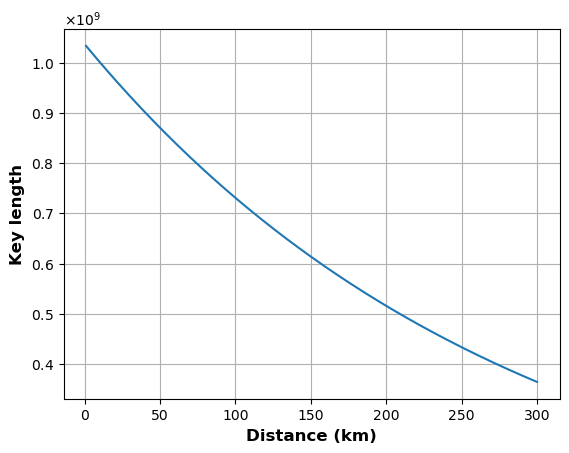

In [5]:
# Python Code for Figure 4 in `Protocols for counterfactual and twin-field quantum digital signature'

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

c_values = np.linspace(1, 300, 300)  # distance (km)
N = 1e10
D = 16
pz = 0.1
pz0 = 0.75
p0 = 0.5
p1 = 0.3
em = 0.03
pd = 1e-7
a1 = 0.15
a2 = 0.1
az = (a1 + a2) / 2
eps = 1e-12

# Probabilities
P0a1 = ((1 - pz) * p0 * (1 - pz) * p1) * np.exp(-((1 - pz) * p0) - ((1 - pz) * p1))
P0a2 = ((1 - pz) * p0 * (1 - pz) * (1 - p0 - p1)) * np.exp(-((1 - pz) * p0) - ((1 - pz) * (1 - p0 - p1)))
Pa1 = ((1 - pz) * p1 * (1 - pz) * p1) * np.exp(-((1 - pz) * p1) - ((1 - pz) * p1))
Pa2 = ((1 - pz) * (1 - p0 - p1) * (1 - pz) * (1 - p0 - p1)) * np.exp(-((1 - pz) * (1 - p0 - p1)) - ((1 - pz) * (1 - p0 - p1)))
tau = P0a1 + P0a2 + Pa1 + Pa2

# Photon counts
N0 = ((((1 - pz)**2) * (p0**2)) + (2 * (1 - pz) * pz * p0 * pz0)) * N
N1 = ((((1 - pz)**2) * p0 * p1) + ((1 - pz) * pz * pz0 * p1)) * N
N2 = ((((1 - pz)**2) * (1 - p0 - p1) * p0) + ((1 - pz) * pz * pz0 * (1 - p0 - p1))) * N
ND = ((D / (2 * np.pi)) * ((1 - pz)**2) * (p1**2)) * N

def transmission_efficiency(distance):
    return 0.5 * 10 ** (-0.3 * distance / 200)

def integrate_T_S(eta, a, D, pd):
    T, _ = integrate.quad(lambda th: ((1 - pd) / D) * np.exp(-2 * eta * a * np.cos(th / 2) ** 2), -D / 2, D / 2)
    T_corr = T - ((1 - pd) ** 2) * np.exp(-2 * eta * a)

    S, _ = integrate.quad(lambda th: ((1 - pd) / D) * np.exp(-2 * eta * a * np.sin(th / 2) ** 2), -D / 2, D / 2)
    S_corr = S - ((1 - pd) ** 2) * np.exp(-2 * eta * a) + T_corr

    return T_corr, S_corr

def entropy(p):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return - (p * np.log2(p) + (1 - p) * np.log2(1 - p))

keys = []

for distance in c_values:
    eta = transmission_efficiency(distance)

    n11 = 2 * ((1 - pd) * np.exp(eta * a1 / 2) - (1 - pd) ** 2 * np.exp(-eta * a1)) * N1
    n22 = 2 * ((1 - pd) * np.exp(eta * a2 / 2) - (1 - pd) ** 2 * np.exp(-eta * a2)) * N2

    T1, S1 = integrate_T_S(eta, a1, D, pd)
    T2, S2 = integrate_T_S(eta, a2, D, pd)

    n00 = 2 * pd * (1 - pd) * N0
    n01 = n11 + np.sqrt(n11 * np.log(1 / eps) / 2)
    n02 = n22 - np.sqrt(n22 * np.log(1 / eps) / 2)

    na1 = (T1 * (1 - 2 * em) + em * S1) * ND
    na2 = (T2 * (1 - 2 * em) + em * S2) * ND

    nf1 = (np.exp(-a1 ** 2) * a1 * (2 * n01)) / P0a1
    nf2 = (np.exp(-a2 ** 2) * a2 * (2 * n02)) / P0a2
    nf3 = np.exp(-a1 ** 2) * a1 * (2 * n00)

    ef1 = (np.exp(-a1 ** 2) * a1 ** 2 * na1) / Pa1
    ef2 = (np.exp(-a2 ** 2) * a2 ** 2 * na2) / Pa2
    ef3 = (np.exp(-a1 ** 2) * np.exp(-a2 ** 2) * a1 ** 2 * a2 ** 2 * 2 * n01) / P0a1

    length = (tau * (nf1 - nf2 - nf3)) / (2 * (a1 - a2))
    error = (tau * (ef1 - ef2 + ef3)) / ((a1 - a2) * length)
    he = entropy(error)

    key = length * (1 - he)
    keys.append(key)

plt.figure()
plt.plot(c_values, keys, label="Key length")

plt.xlabel('Distance (km)', fontsize=12, fontweight='bold')
plt.ylabel('Key length', fontsize=12, fontweight='bold')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
plt.grid(True)

plt.savefig("tfqds.png", dpi=2000)
plt.savefig("Figure4.pdf", bbox_inches='tight')
plt.show()
